In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)




MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd /content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs


/content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs


In [ ]:
!pip install python-dotenv

In [ ]:
pip install plotly


=== Summary statistics ===
             auto_mean  human_mean  auto_std  human_std
Fluency           4.10        5.00  0.307794   0.000000
Coherence         5.00        5.00  0.000000   0.000000
Realism           4.10        5.00  0.307794   0.000000
Fidelity          4.70        3.25  0.470162   0.638666
Engagement        4.05        4.10  0.223607   0.307794
Originality       3.05        3.55  0.223607   0.510418

=== Auto vs. Human Correlation (valid columns only) ===
                    Fidelity (human)  Engagement (human)  Originality (human)
Fluency (auto)              0.401610           -0.111111            -0.033501
Realism (auto)              0.401610           -0.111111            -0.033501
Fidelity (auto)             0.262915           -0.145479            -0.153522
Engagement (auto)          -0.092136            0.688247             0.207514
Originality (auto)         -0.092136           -0.076472             0.207514


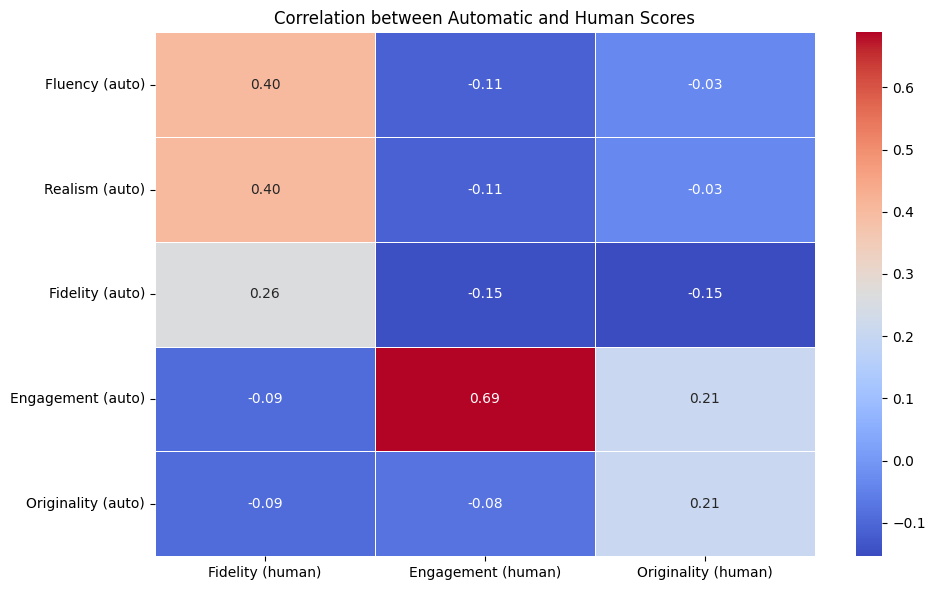

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

# Set Plotly rendering mode for Google Colab
pio.renderers.default = 'colab'

# === Load Excel file ===
file_path = "/content/drive/MyDrive/local_remote_synthetic_dialogs_copia/synthetic_dialogs/data_llama3_8b_noimperf/evaluation_human_template_noimperf_llama3_8b.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces in column names

# === Define evaluation criteria ===
criteria = ["Fluency", "Coherence", "Realism", "Fidelity", "Engagement", "Originality"]
auto_cols = [f"{c} (auto)" for c in criteria]
human_cols = [f"{c} (human)" for c in criteria]

# === Convert all scoring columns to numeric (in case of text or errors) ===
for col in auto_cols + human_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# === Keep only rows with valid human scores ===
df_clean = df.dropna(subset=human_cols)

# === Summary statistics: means and standard deviations ===
summary = pd.DataFrame(index=criteria)
summary["auto_mean"] = [df_clean[f"{c} (auto)"].mean() for c in criteria]
summary["human_mean"] = [df_clean[f"{c} (human)"].mean() for c in criteria]
summary["auto_std"] = [df_clean[f"{c} (auto)"].std() for c in criteria]
summary["human_std"] = [df_clean[f"{c} (human)"].std() for c in criteria]

print("=== Summary statistics ===")
print(summary)

# === Identify only columns with non-zero variance ===
valid_human_cols = [col for col in human_cols if df_clean[col].std() > 0]
valid_auto_cols = [col for col in auto_cols if df_clean[col].std() > 0]

# === Compute correlation matrix only for valid columns ===
corr_matrix = df_clean[valid_auto_cols + valid_human_cols].corr()
corr = corr_matrix.loc[valid_auto_cols, valid_human_cols]

print("\n=== Auto vs. Human Correlation (valid columns only) ===")
print(corr)

# === Interactive boxplot for score distributions ===
melted = df_clean.melt(value_vars=auto_cols + human_cols, var_name="Metric", value_name="Score")
fig_box = px.box(melted, x="Metric", y="Score", title="Score Distribution: Auto vs. Human")
fig_box.update_layout(xaxis_tickangle=45, width=1000, height=500)
display(fig_box)

# === Scatterplots for each valid metric with reference line y = x ===
for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    # Plot only if both columns have variance
    if (
        auto_col in df_clean.columns and human_col in df_clean.columns and
        df_clean[auto_col].std() > 0 and df_clean[human_col].std() > 0
    ):
        fig = px.scatter(
            df_clean, x=auto_col, y=human_col,
            title=f"{c}: Auto vs Human",
            labels={auto_col: "Auto Score", human_col: "Human Score"},
            range_x=[0, 5], range_y=[0, 5]
        )

        # Add diagonal reference line (ideal match)
        fig.add_trace(go.Scatter(
            x=[0, 5], y=[0, 5],
            mode='lines',
            line=dict(dash='dash', color='gray'),
            name='Ideal Match (y=x)'
        ))

        fig.update_layout(width=800, height=800)
        display(fig)

# === Correlation heatmap (NaNs are masked) ===
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=corr.isnull())
plt.title("Correlation between Automatic and Human Scores")
plt.tight_layout()
plt.show()


During the analysis, some human-evaluated metrics resulted in NaN values in the correlation matrix. This was caused by a lack of variance in the scores: certain human evaluation columns (e.g., Fluency (human) and Coherence (human)) had identical values across all samples (e.g., all rated 5.0). Since the standard deviation of these columns was zero, computing correlation was mathematically undefined, leading to missing values. To ensure valid results, only those metrics with non-zero variance were included in the correlation and scatterplot visualizations.

To complement the correlation and descriptive analysis, we computed two additional metrics: the Mean Absolute Error (MAE) and the Bias for each evaluation criterion. MAE measures the average absolute difference between automatic and human scores, indicating the overall error magnitude. Bias reflects whether the model systematically overestimates or underestimates human ratings (positive values indicate overestimation). These metrics provide a more nuanced understanding of alignment and deviations between automatic and human evaluations.



---

|      | MAE                                                     | Bias (Auto - Human) |
| ---- | ------------------------------------------------------- | ------------------- |
| MAE  | The lower, the better (0 = perfect match).              |                     |
| Bias | > 0 → the system **overestimates** compared to humans.  |                     |
|      | < 0 → the system **underestimates** compared to humans. |                     |



In [ ]:
from sklearn.metrics import mean_absolute_error

# === MAE and Bias per metric ===
mae = []
bias = []

for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    if auto_col in df_clean.columns and human_col in df_clean.columns:
        if df_clean[auto_col].std() > 0 or df_clean[human_col].std() > 0:
            # Calculate MAE (ignoring NaNs)
            mae_val = mean_absolute_error(df_clean[human_col], df_clean[auto_col])
            mae.append(mae_val)

            # Calculate Bias (mean difference)
            bias_val = df_clean[auto_col].mean() - df_clean[human_col].mean()
            bias.append(bias_val)
        else:
            mae.append(None)
            bias.append(None)
    else:
        mae.append(None)
        bias.append(None)

# Combine into a summary DataFrame
extra_stats = pd.DataFrame({
    "MAE": mae,
    "Bias (Auto - Human)": bias
}, index=criteria)

print("\n=== Extra Evaluation Metrics ===")
print(extra_stats)



=== Extra Evaluation Metrics ===
              MAE  Bias (Auto - Human)
Fluency      0.90                -0.90
Coherence     NaN                  NaN
Realism      0.90                -0.90
Fidelity     1.45                 1.45
Engagement   0.05                -0.05
Originality  0.50                -0.50


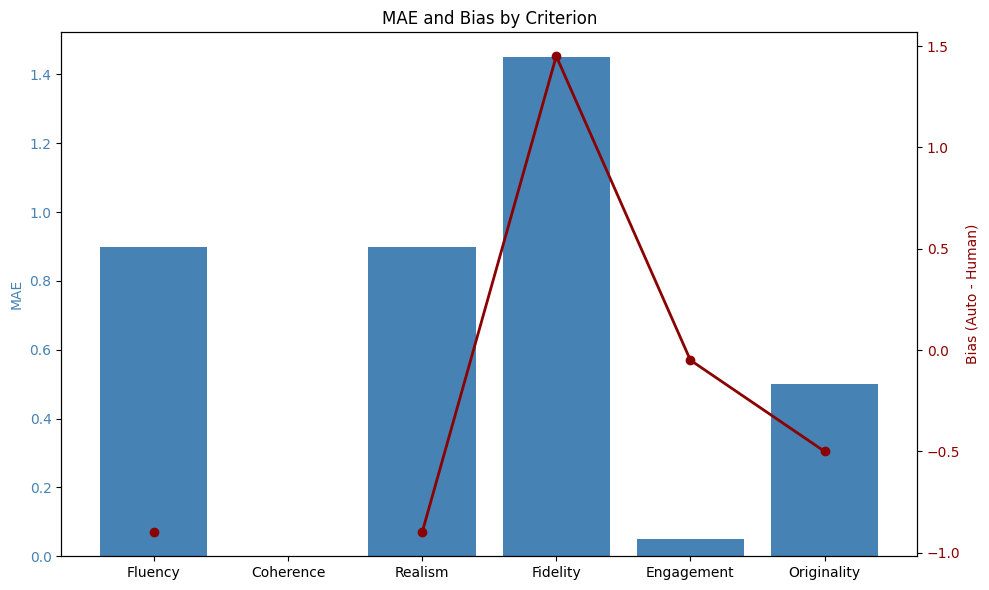

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Define evaluation criteria
criteria = ["Fluency", "Coherence", "Realism", "Fidelity", "Engagement", "Originality"]
auto_cols = [f"{c} (auto)" for c in criteria]
human_cols = [f"{c} (human)" for c in criteria]

# Compute MAE and Bias
mae = []
bias = []

for c in criteria:
    auto_col = f"{c} (auto)"
    human_col = f"{c} (human)"

    if auto_col in df_clean.columns and human_col in df_clean.columns:
        if df_clean[auto_col].std() > 0 or df_clean[human_col].std() > 0:
            # Mean Absolute Error between human and auto scores
            mae_val = mean_absolute_error(df_clean[human_col], df_clean[auto_col])
            # Bias: average difference (auto - human)
            bias_val = df_clean[auto_col].mean() - df_clean[human_col].mean()
            mae.append(mae_val)
            bias.append(bias_val)
        else:
            mae.append(None)
            bias.append(None)
    else:
        mae.append(None)
        bias.append(None)

# Create summary DataFrame
extra_stats = pd.DataFrame({
    "MAE": mae,
    "Bias (Auto - Human)": bias
}, index=criteria)

# Combined bar/line chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MAE as bars
ax1.bar(extra_stats.index, extra_stats["MAE"], color="steelblue", label="MAE")
ax1.set_ylabel("MAE", color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")

# Plot Bias as a line on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(extra_stats.index, extra_stats["Bias (Auto - Human)"], color="darkred", marker="o", linewidth=2, label="Bias")
ax2.set_ylabel("Bias (Auto - Human)", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("MAE and Bias by Criterion")
plt.tight_layout()
plt.show()


Fidelity tiene mucho error (MAE alto) y un bias positivo fuerte → el sistema sobrevalora bastante respecto a humanos.

Engagement tiene un MAE muy bajo → el sistema y humanos coinciden bastante.